In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from fancyimpute import KNN
from functools import reduce
import plotly.express as px
import plotly.graph_objects as go 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import plotly.io as pio
pio.renderers.default='notebook'
from sklearn.metrics import (confusion_matrix,
                           accuracy_score)
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

(CVXPY) Dec 08 02:28:32 PM: Encountered unexpected exception importing solver SCS:
ImportError('dlopen(/Users/amrita/opt/anaconda3/lib/python3.7/site-packages/_scs_direct.cpython-37m-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: /Users/amrita/opt/anaconda3/lib/python3.7/site-packages/scs/.dylibs/libgomp.1.dylib (which was built for Mac OS X 10.15)\n  Expected in: /usr/lib/libSystem.B.dylib\n in /Users/amrita/opt/anaconda3/lib/python3.7/site-packages/scs/.dylibs/libgomp.1.dylib')


In [2]:
# We import the dataset that we created in our Data Wrangling section of the Capstone project 
# Import the dataset

df=pd.read_csv('/Users/amrita/Desktop/Springboard/new_df.csv')
df.head()

,satisfaction,Age,Flight_Distance,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,Seat_comfort,Departure/Arrival_time_convenient,Food_and_drink,Gate_location,Inflight_wifi_service,...,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Eco,Eco_Plus,disloyal_Customer,Personal_Travel,Male
0,1,1.691495,-1.671090,-0.386036,-0.392329,0,0,0,2,2,...,0,3,5,3,2,1,0,0,1,0
1,1,0.500825,0.470348,7.786328,7.536854,0,0,0,3,0,...,4,4,2,3,2,0,0,0,1,1
2,1,-1.615922,0.152882,-0.386036,-0.392329,0,0,0,3,2,...,3,4,4,4,2,1,0,0,1,0
3,1,1.360753,-1.322461,-0.386036,-0.392329,0,0,0,3,3,...,0,1,4,1,3,1,0,0,1,0
4,1,2.022237,-1.584420,-0.386036,-0.392329,0,0,0,3,4,...,0,2,4,2,5,1,0,0,1,0


# Check Correlations

In [3]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr(method= 'spearman').abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 30))

Top Absolute Correlations
Departure_Delay_in_Minutes         Arrival_Delay_in_Minutes             0.740284
Seat_comfort                       Food_and_drink                       0.705452
Ease_of_Online_booking             Online_boarding                      0.662621
Online_support                     Online_boarding                      0.650395
Baggage_handling                   Cleanliness                          0.641254
Inflight_wifi_service              Online_boarding                      0.616602
Online_support                     Ease_of_Online_booking               0.603637
Inflight_wifi_service              Ease_of_Online_booking               0.579588
On_board_service                   Cleanliness                          0.578680
satisfaction                       Inflight_entertainment               0.577601
On_board_service                   Baggage_handling                     0.555065
Departure/Arrival_time_convenient  Gate_location                        0.554920
  

In [4]:
# The following variables are dropped based on VIF analysis and the final model was re-fit.

df=df.drop('Ease_of_Online_booking', axis=1)

In [5]:
df=df.drop(['Baggage_handling', 'Cleanliness'], axis=1)

In [6]:
df=df.drop(['Online_support'], axis=1)

In [7]:
df=df.drop(['Food_and_drink','Inflight_wifi_service'], axis=1)

In [8]:
df=df.drop(['Departure_Delay_in_Minutes'], axis=1)

In [9]:
df

,satisfaction,Age,Flight_Distance,Arrival_Delay_in_Minutes,Seat_comfort,Departure/Arrival_time_convenient,Gate_location,Inflight_entertainment,On_board_service,Leg_room_service,Checkin_service,Online_boarding,Eco,Eco_Plus,disloyal_Customer,Personal_Travel,Male
0,1,1.691495,-1.671090,-0.392329,0,0,2,4,3,0,5,2,1,0,0,1,0
1,1,0.500825,0.470348,7.536854,0,0,3,2,4,4,2,2,0,0,0,1,1
2,1,-1.615922,0.152882,-0.392329,0,0,3,0,3,3,4,2,1,0,0,1,0
3,1,1.360753,-1.322461,-0.392329,0,0,3,4,1,0,4,3,1,0,0,1,0
4,1,2.022237,-1.584420,-0.392329,0,0,3,3,2,0,4,5,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129482,1,-0.689845,-0.243465,-0.392329,5,5,3,5,3,3,4,2,1,0,1,1,0
129483,0,1.559198,0.103217,4.079210,2,3,4,1,2,3,1,1,0,0,1,1,1
129484,0,1.956088,0.330117,3.845234,3,0,3,2,4,3,2,2,1,0,1,1,1
129485,0,1.757643,0.456714,4.937122,3,2,2,2,3,2,2,2,1,0,1,1,1


In [10]:
# With statsmodel 
# Train-test split 80:20

train, test = train_test_split(df, test_size=0.2)
col = "satisfaction"
xtest= test.loc[:, test.columns != col]
ytest= test[['satisfaction']]
col = "satisfaction"
xtrain = train.loc[:, train.columns != col]
ytrain= train[['satisfaction']]
model= sm.GLM(ytrain, xtrain, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           satisfaction   No. Observations:               103589
Model:                            GLM   Df Residuals:                   103573
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46134.
Date:                Thu, 08 Dec 2022   Deviance:                       92269.
Time:                        14:28:36   Pearson chi2:                 1.17e+05
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Age   

In [11]:
# Model with Scikit Learn

X_train_newseed, X_test_newseed, y_train_newseed,y_test_newseed = train_test_split(df, df.satisfaction, test_size=0.2, random_state=4)
X_train_newseed.drop('satisfaction', axis=1, inplace=True)
X_test_newseed.drop('satisfaction', axis=1, inplace=True)
model_scikit = LogisticRegression(max_iter=10000).fit(X_train_newseed, y_train_newseed)
y_pred= model_scikit.predict(X_test_newseed)

In [12]:
#training 

y_pred_newseed1=model_scikit.predict(X_train_newseed)

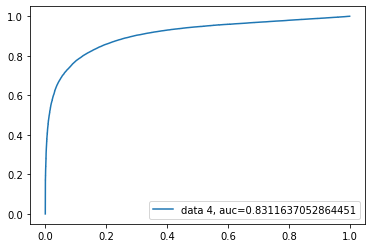

In [13]:
# AUC (training)

from sklearn import metrics

y_pred_proba_newseed1 = model_scikit.predict_proba(X_train_newseed)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train_newseed,  y_pred_proba_newseed1)
auc_newseed1 = metrics.roc_auc_score(y_train_newseed, y_pred_newseed1)
plt.plot(fpr,tpr,label="data 4, auc="+str(auc_newseed1))
plt.legend(loc=4)
plt.show()

In [14]:
y_pred_newseed1.shape

(103589,)

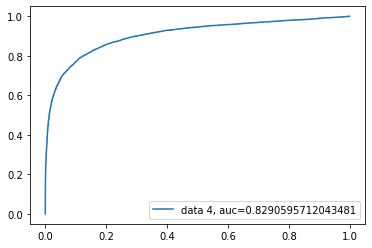

In [15]:
# AUC

from sklearn import metrics

y_pred_proba_newseed = model_scikit.predict_proba(X_test_newseed)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_newseed,  y_pred_proba_newseed)
auc_newseed = metrics.roc_auc_score(y_test_newseed, y_pred)
plt.plot(fpr,tpr,label="data 4, auc="+str(auc_newseed))
plt.legend(loc=4)
plt.show()

In [16]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test_newseed, y_pred))
print("Precision:",metrics.precision_score(y_test_newseed, y_pred))
print("Recall:",metrics.recall_score(y_test_newseed, y_pred))

Accuracy: 0.8314155533245811
Precision: 0.8393998332870242
Recall: 0.8547177818644787


In [17]:
# get feature importance 

importances = pd.DataFrame(data={
    'Attribute': xtrain.columns,
    'Importance': model_scikit.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

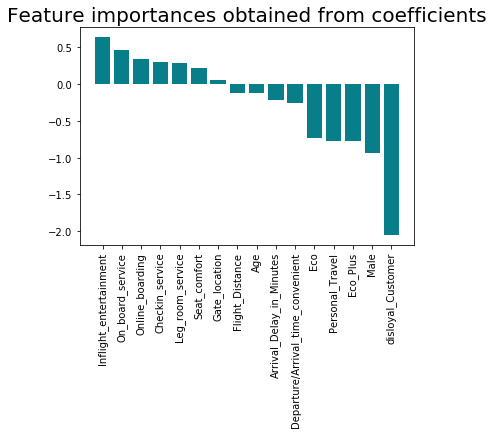

In [18]:
# Plot feature importance 

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Check VIF for multicollinearity

In [19]:
X_new_nested=df.drop(['satisfaction'], axis=1)
vif_data_nested = pd.DataFrame()
vif_data_nested["feature"] = X_new_nested.columns

In [20]:
vif_data_nested["VIF"] = [variance_inflation_factor(X_new_nested.values, i)
                          for i in range(len(X_new_nested.columns))]

In [21]:
vif_data_nested.sort_values("VIF")

,feature,VIF
2,Arrival_Delay_in_Minutes,1.016725
1,Flight_Distance,1.156264
0,Age,1.217909
12,Eco_Plus,1.257224
13,disloyal_Customer,1.733604
15,Male,1.925005
14,Personal_Travel,2.789679
11,Eco,3.163542
4,Departure/Arrival_time_convenient,8.249235
10,Online_boarding,8.440939


# GradientBoost Classifier

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(xtrain, ytrain.values.ravel())
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(xtrain, ytrain)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(xtest, ytest)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.848
Accuracy score (validation): 0.849

Learning rate:  0.1
Accuracy score (training): 0.857
Accuracy score (validation): 0.860

Learning rate:  0.25
Accuracy score (training): 0.869
Accuracy score (validation): 0.871

Learning rate:  0.5
Accuracy score (training): 0.896
Accuracy score (validation): 0.899

Learning rate:  0.75
Accuracy score (training): 0.892
Accuracy score (validation): 0.893

Learning rate:  1
Accuracy score (training): 0.894
Accuracy score (validation): 0.895



In [24]:
gb1 = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 4)
gb1.fit(xtrain, ytrain.values.ravel())
print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(gb1.score(xtrain, ytrain)))
print("Accuracy score (validation): {0:.3f}".format(gb1.score(xtest, ytest)))
print()

Learning rate:  1
Accuracy score (training): 0.882
Accuracy score (validation): 0.883



In [25]:
#training 

y_pred_gb1=gb1.predict(xtrain)

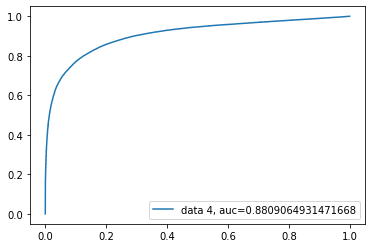

In [26]:
# AUC (training)

from sklearn import metrics

y_pred_proba_gb1 = model_scikit.predict_proba(xtrain)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytrain,  y_pred_proba_gb1)
auc_newseed_gb1 = metrics.roc_auc_score(ytrain, y_pred_gb1)
plt.plot(fpr,tpr,label="data 4, auc="+str(auc_newseed_gb1))
plt.legend(loc=4)
plt.show()

In [27]:
#test
ypred2 = gb1.predict(xtest)

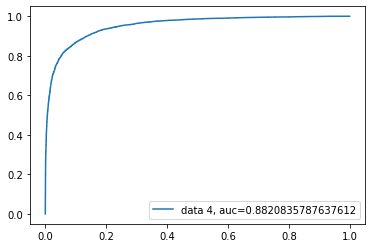

In [28]:
# AUC (test)


y_pred_proba = gb1.predict_proba(xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred_proba)
auc = metrics.roc_auc_score(ytest, ypred2)
plt.plot(fpr,tpr,label="data 4, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [29]:
tt=xtest

In [30]:
tt['pred']=y_pred_proba

In [31]:
tt['original']= ytest

In [32]:
tt

,Age,Flight_Distance,Arrival_Delay_in_Minutes,Seat_comfort,Departure/Arrival_time_convenient,Gate_location,Inflight_entertainment,On_board_service,Leg_room_service,Checkin_service,Online_boarding,Eco,Eco_Plus,disloyal_Customer,Personal_Travel,Male,pred,original
2762,1.294605,-1.521121,-0.106358,5,4,3,4,5,5,3,4,1,0,0,1,0,0.924366,1
52941,-1.152884,0.018494,-0.392329,3,3,2,3,4,3,2,4,1,0,1,0,1,0.034685,0
85698,0.103935,-1.572734,-0.392329,3,1,1,4,3,3,2,1,0,0,0,0,1,0.415897,0
91562,1.162308,0.249290,-0.392329,5,5,5,4,4,4,3,4,0,0,0,0,0,0.933500,1
73260,0.434677,-0.066229,0.387591,2,1,1,2,1,3,3,2,1,0,0,0,1,0.038623,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51882,-1.946664,-0.464523,-0.392329,3,2,4,3,2,1,2,2,1,0,1,0,1,0.009638,0
60283,-1.946664,0.087635,-0.392329,4,4,4,4,5,2,3,5,1,0,1,0,0,0.642908,0
8698,-0.954439,0.808265,-0.236345,2,1,3,2,2,5,4,2,1,0,0,1,1,0.089322,0
40269,-2.012812,-0.040909,-0.392329,0,0,4,0,4,5,4,5,1,0,1,0,1,0.918123,1


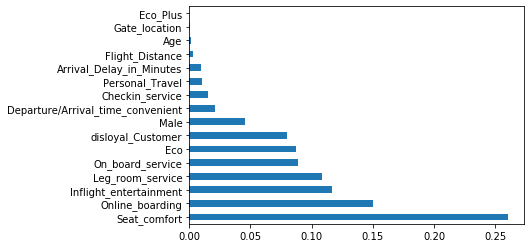

In [33]:
# Get feature importances

(pd.Series(gb1.feature_importances_, index=xtrain.columns)
   .nlargest(20)
   .plot(kind='barh'))